Offsets found: [-100  100  300]


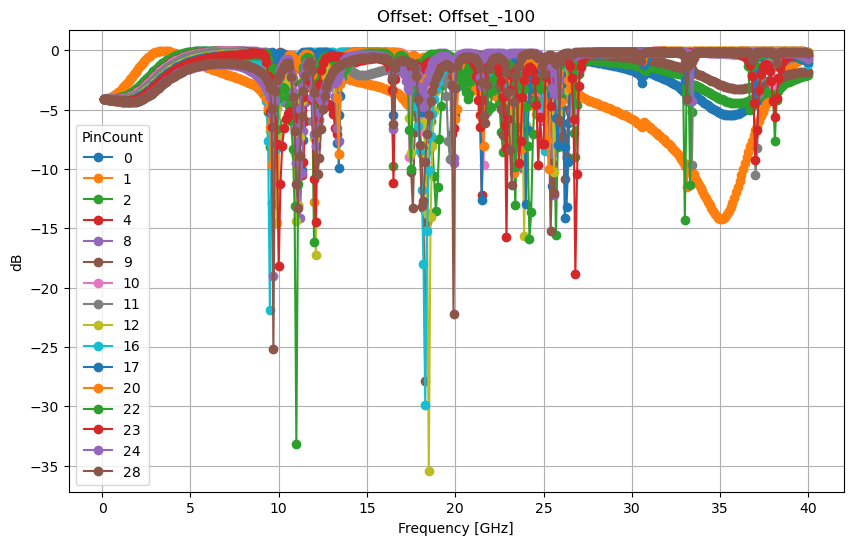

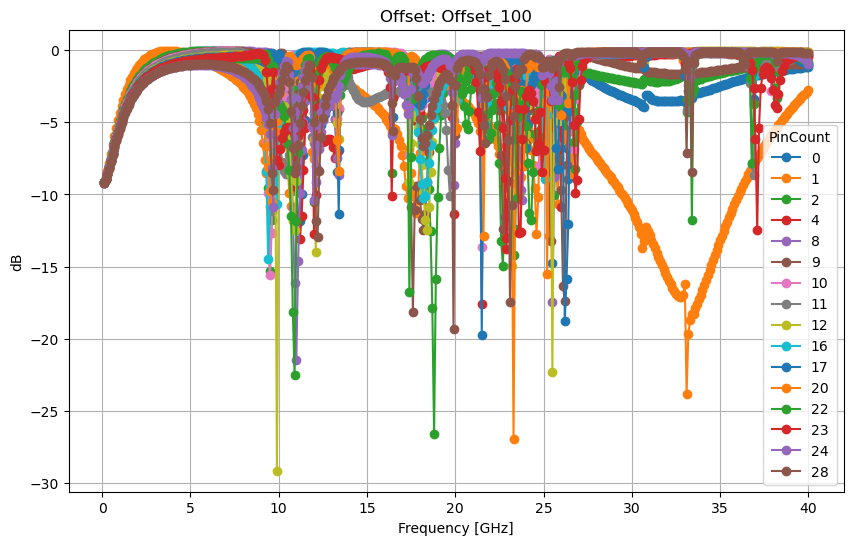

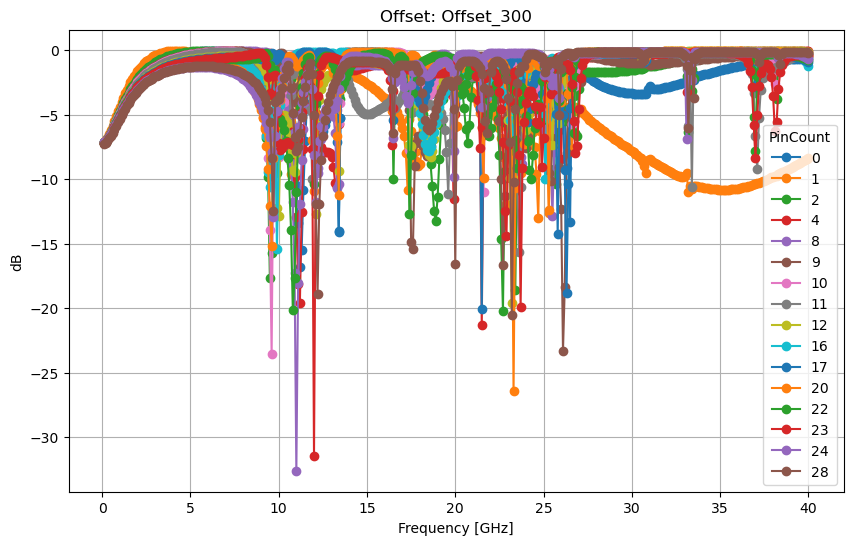

{'Offset_-100': PinCount []  Freq [GHz]         0         1         2         4         8  \
 0                   0.1 -4.107876 -4.094584 -4.107329 -4.110277 -4.110241   
 1                   0.2 -4.111044 -4.075969 -4.110004 -4.116680 -4.117702   
 2                   0.3 -4.110453 -4.042923 -4.108656 -4.121018 -4.123945   
 3                   0.4 -4.106560 -3.995729 -4.103735 -4.123796 -4.129456   
 4                   0.5 -4.099211 -3.934461 -4.095092 -4.124876 -4.134092   
 ..                  ...       ...       ...       ...       ...       ...   
 395                39.6 -2.036325 -0.693377 -2.226393 -0.103395 -0.371559   
 396                39.7 -1.980032 -0.613996 -2.180288 -0.104248 -0.385631   
 397                39.8 -1.926046 -0.542339 -2.136562 -0.105143 -0.405747   
 398                39.9 -1.874314 -0.478124 -2.095026 -0.106096 -0.436292   
 399                40.0 -1.824808 -0.421198 -2.055444 -0.107146 -0.486811   
 
 PinCount []         9        10        11     

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# Load CSV
# -----------------------------
filename = 'Terminal S Parameter Plot 600z discrete'
csv_filename = filename + '.csv'
df = pd.read_csv(csv_filename)

# -----------------------------
# Build sheets_dict (Freq as COLUMN)
# -----------------------------
offsets = df['offset [um]'].dropna().unique()
print("Offsets found:", offsets)

sheets_dict = {}

for offset in offsets:
    offset_data = df[df['offset [um]'] == offset]

    pivoted = offset_data.pivot_table(
        index='Freq [GHz]',
        columns='PinCount []',
        values='dB(St(VCC_moving_T1,VCC_moving_T1)) []',
        aggfunc='mean'
    ).reset_index()  

    sheets_dict[f'Offset_{offset}'] = pivoted

# -----------------------------
# Plotting 
# -----------------------------
for sheet_name, df_sheet in sheets_dict.items():
    plt.figure(figsize=(10, 6))

    # Plot each pin-count column (everything except Freq)
    for pin_col in df_sheet.columns[1:]:
        plt.plot(df_sheet['Freq [GHz]'], df_sheet[pin_col], marker='o', label=str(pin_col))

    plt.xlabel('Frequency [GHz]')
    plt.ylabel('dB')
    plt.title(f'Offset: {sheet_name}')
    plt.legend(title='PinCount')
    plt.grid(True)
    plt.show()

# Output for next steps
sheets_dict


In [2]:
# Function to find pairs where -3dB falls between them and label as rising or falling
threshold = -3
def find_intersection_pairs(freq, dB_values, threshold):
    pairs = []
    for i in range(1, len(dB_values)):
        if (dB_values[i-1] > threshold and dB_values[i] <= threshold) or \
           (dB_values[i-1] <= threshold and dB_values[i] > threshold):
            pair = (freq[i-1], freq[i], dB_values[i-1], dB_values[i])
            pair_type = "rising" if pair[3] - pair[2] > 0 else "falling"
            pairs.append((pair, pair_type))
    return pairs

# Function to find the first rising and falling pairs or return "NA"
def find_first_rising_falling_pairs(pairs):
    first_rising = next(((pair, pair_type) for pair, pair_type in pairs if pair_type == "rising"), None)
    first_falling = next(((pair, pair_type) for pair, pair_type in pairs if pair_type == "falling"), None)
    return first_rising, first_falling

# Function to calculate linearly scaled frequency based on initial and final dB values
def calculate_scaled_frequency(initial_freq, final_freq, initial_dB, final_dB, threshold):
    scaled_freq = initial_freq + ((final_freq - initial_freq) / (final_dB - initial_dB)) * (threshold - initial_dB)
    return scaled_freq

# Dictionary to store rising frequencies for each pin count
rising_frequencies = {}
falling_frequencies = {}

# Iterate through each sheet to find intersection pairs and label as rising or falling
labeled_pairs = {}
first_pairs = {}
scaled_frequencies = {}

for sheet_name, df in sheets_dict.items():
    offset = sheet_name.split('_')[-1]
    labeled_pairs[offset] = {}
    first_pairs[offset] = {}
    scaled_frequencies[offset] = {}
    for pin_count in df.columns[1:]:
        freq = df['Freq [GHz]'].values
        dB_values = df[pin_count].values
        intersection_pairs = find_intersection_pairs(freq, dB_values, threshold)
        labeled_pairs[offset][pin_count] = intersection_pairs
        first_rising, first_falling = find_first_rising_falling_pairs(intersection_pairs)
        first_pairs[offset][pin_count] = {'First_Rising': first_rising, 'First_Falling': first_falling}
        
        if first_rising:
            initial_freq_rising = first_rising[0][0]
            final_freq_rising = first_rising[0][1]
            initial_dB_rising = first_rising[0][2]
            final_dB_rising = first_rising[0][3]
            scaled_freq_rising = calculate_scaled_frequency(initial_freq_rising, final_freq_rising, \
                                                            initial_dB_rising, final_dB_rising, threshold)
            scaled_frequencies[offset][str(pin_count) + '_rising'] = scaled_freq_rising
            rising_frequencies[pin_count] = scaled_freq_rising
        
        if first_falling:
            initial_freq_falling = first_falling[0][0]
            final_freq_falling = first_falling[0][1]
            initial_dB_falling = first_falling[0][2]
            final_dB_falling = first_falling[0][3]
            scaled_freq_falling = calculate_scaled_frequency(initial_freq_falling, final_freq_falling, \
                                                             initial_dB_falling, final_dB_falling, threshold)
            scaled_frequencies[offset][str(pin_count) + '_falling'] = scaled_freq_falling
            falling_frequencies[pin_count] = scaled_freq_falling

# Print the labeled intersection pairs for each offset and pin count
for offset, data in labeled_pairs.items():
    print(f"Offset: {offset}")
    for pin_count, pairs in data.items():
        print(f"  Pin Count: {pin_count}")
        for pair, pair_type in pairs:
            print(f"    Pair: {pair} - Type: {pair_type}")

# Print the first rising and falling pairs for each offset and pin count
for offset, data in first_pairs.items():
    print(f"Offset: {offset}")
    for pin_count, pairs in data.items():
        print(f"  Pin Count: {pin_count}")
        if pairs['First_Rising'] is not None:
            print(f"    First Rising Pair: {pairs['First_Rising'][0]} - Type: {pairs['First_Rising'][1]}")
        else:
            print("    First Rising Pair: NA")
        if pairs['First_Falling'] is not None:
            print(f"    First Falling Pair: {pairs['First_Falling'][0]} - Type: {pairs['First_Falling'][1]}")
        else:
            print("    First Falling Pair: NA")

# Print the linearly scaled frequencies for each offset and pin count
for offset, data in scaled_frequencies.items():
    print(f"Offset: {offset}")
    for freq_type, scaled_freq in data.items():
        print(f"  {freq_type.capitalize()} Frequency: {scaled_freq:.3f} GHz")


Offset: -100
  Pin Count: 0
    Pair: (np.float64(2.1), np.float64(2.2), np.float64(-3.05423286789976), np.float64(-2.91378313555405)) - Type: rising
    Pair: (np.float64(10.6), np.float64(10.7), np.float64(-2.8602291686266), np.float64(-3.36412260322586)) - Type: falling
    Pair: (np.float64(11.5), np.float64(11.6), np.float64(-4.35675326553646), np.float64(-2.24327712265454)) - Type: rising
    Pair: (np.float64(12.0), np.float64(12.1), np.float64(-2.59170100775598), np.float64(-3.33133557223097)) - Type: falling
    Pair: (np.float64(12.8), np.float64(12.9), np.float64(-3.03955083025072), np.float64(-2.85050576098678)) - Type: rising
    Pair: (np.float64(13.0), np.float64(13.1), np.float64(-2.79803004307416), np.float64(-3.01528755861628)) - Type: falling
    Pair: (np.float64(13.4), np.float64(13.5), np.float64(-5.46933761284), np.float64(-1.81700137861091)) - Type: rising
    Pair: (np.float64(17.9), np.float64(18.0), np.float64(-1.9613328748707), np.float64(-3.36266922145732))

In [3]:
def get_frequency_for_offset_pincount(offset, pin_count, frequency_type):
    if frequency_type.lower() == 'rising':
        freq_dict = rising_frequencies
    elif frequency_type.lower() == 'falling':
        freq_dict = falling_frequencies
    else:
        print("Invalid frequency type. Please choose 'rising' or 'falling'.")
        return None
    freq_key = str(pin_count) + '_' + frequency_type.lower()
    if offset in scaled_frequencies and freq_key in scaled_frequencies[offset]:
        return scaled_frequencies[offset][freq_key]
    else:
        print("Frequency not found for the specified offset and pin count.")
        return None
    
def get_frequencies_for_offset(offset, frequency_type):
    if frequency_type.lower() == 'rising':
        freq_dict = rising_frequencies
    elif frequency_type.lower() == 'falling':
        freq_dict = falling_frequencies
    else:
        print("Invalid frequency type. Please choose 'rising' or 'falling'.")
        return None
    result = {}
    for pin_count, freq in freq_dict.items():
        if offset in scaled_frequencies and str(pin_count) + '_' + frequency_type.lower() in scaled_frequencies[offset]:
            result[pin_count] = scaled_frequencies[offset][str(pin_count) + '_' + frequency_type.lower()]
    if not result:
        print("No frequencies found for the specified offset and frequency type.")
        return None
    
    return result

# Example usage:
offset_selected = str(offsets[0])
frequency_type_selected = 'rising'
selected_frequencies = get_frequencies_for_offset(offset_selected, frequency_type_selected)

if selected_frequencies is not None:
    print(f"Frequencies for Offset {offset_selected} and Type {frequency_type_selected}:")
    for pin_count, freq in selected_frequencies.items():
        print(f"  Pin Count {pin_count}: {freq:.3f} GHz")

Frequencies for Offset -100 and Type rising:
  Pin Count 0: 2.139 GHz
  Pin Count 1: 1.276 GHz
  Pin Count 2: 2.105 GHz
  Pin Count 4: 2.397 GHz
  Pin Count 8: 2.530 GHz
  Pin Count 9: 2.369 GHz
  Pin Count 10: 2.450 GHz
  Pin Count 11: 2.555 GHz
  Pin Count 12: 2.793 GHz
  Pin Count 16: 2.970 GHz
  Pin Count 17: 2.870 GHz
  Pin Count 20: 3.162 GHz
  Pin Count 22: 2.995 GHz
  Pin Count 23: 3.000 GHz
  Pin Count 24: 3.292 GHz
  Pin Count 28: 3.321 GHz


In [4]:
# Create a new dictionary with values <= 10
filtered_frequencies = {key: value for key, value in selected_frequencies.items() if value <= 8}

print(filtered_frequencies)

{0: np.float64(2.138613721075857), 1: np.float64(1.2762109140129558), 2: np.float64(2.1048956303577375), 4: np.float64(2.3971592564592683), 8: np.float64(2.5304306735264066), 9: np.float64(2.369453136222007), 10: np.float64(2.450181291435328), 11: np.float64(2.554868757015206), 12: np.float64(2.792705329336986), 16: np.float64(2.970267933958046), 17: np.float64(2.870170898649554), 20: np.float64(3.161798868083221), 22: np.float64(2.9950763213318914), 23: np.float64(3.00030276175735), 24: np.float64(3.292326339951602), 28: np.float64(3.3213396931733015)}


In [5]:
scaled_frequencies

{'-100': {'0_rising': np.float64(2.138613721075857),
  '0_falling': np.float64(10.627738172751656),
  '1_rising': np.float64(1.2762109140129558),
  '1_falling': np.float64(8.644317186603898),
  '2_rising': np.float64(2.1048956303577375),
  '2_falling': np.float64(9.226735381763469),
  '4_rising': np.float64(2.3971592564592683),
  '4_falling': np.float64(9.842946883360433),
  '8_rising': np.float64(2.5304306735264066),
  '8_falling': np.float64(9.822901001858085),
  '9_rising': np.float64(2.369453136222007),
  '9_falling': np.float64(9.373761830353581),
  '10_rising': np.float64(2.450181291435328),
  '10_falling': np.float64(9.27111543298855),
  '11_rising': np.float64(2.554868757015206),
  '11_falling': np.float64(9.475735442662478),
  '12_rising': np.float64(2.792705329336986),
  '12_falling': np.float64(9.36722164647285),
  '16_rising': np.float64(2.970267933958046),
  '16_falling': np.float64(9.208795947120718),
  '17_rising': np.float64(2.870170898649554),
  '17_falling': np.float6

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
%matplotlib inline

# Define matrix size and coordinates parameters
xballshift = 1  # Adjust as needed
yballshift = 1  # Adjust as needed
matrix_size = (8, 8)  # Adjust as needed

# Function to map rising frequencies to matrix coordinates
def map_rising_frequencies(rising_frequencies, matrix_size, xballshift, yballshift):
    matrix = [[0 for _ in range(matrix_size[1])] for _ in range(matrix_size[0])]
    for pin_count, freq in rising_frequencies.items():
        yshiftVCCabs = int(pin_count) // 4
        y_coord = ((int(pin_count) % (matrix_size[1] // 2)) * 2 * xballshift + ((yshiftVCCabs % 2) == 0) * xballshift)
        x_coord = (yshiftVCCabs * yballshift)
        matrix[y_coord][x_coord] = freq
    return matrix

# Define a function to check if a cell is surrounded by zeros
def surrounded_by_zeros(matrix, i, j):
    m, n = len(matrix), len(matrix[0])
    for di in range(-1, 2):
        for dj in range(-1, 2):
            if 0 <= i + di < m and 0 <= j + dj < n:
                if matrix[i + di][j + dj] != 0:
                    return False
    return True

def process_matrix_data(offset, matrix_size, xballshift, yballshift):
    # Example usage:
    offset_selected = str(offsets[offset])
    pin_count_selected = 0
    frequency_type_selected = 'rising'
    selected_frequencies =  get_frequencies_for_offset(offset_selected, frequency_type_selected)

    # Map rising frequencies to matrix coordinates
    matrix_data = map_rising_frequencies(selected_frequencies, matrix_size, xballshift, yballshift)

    # Calculate the maximum value in the matrix
    max_value = max(max(row) for row in matrix_data)

    # Create a new matrix to store the modified values
    new_matrix_data = [row.copy() for row in matrix_data]

    # Iterate through each cell in the matrix
    for i in range(len(matrix_data)):
        for j in range(len(matrix_data[0])):
            if matrix_data[i][j] == 0:
                if surrounded_by_zeros(matrix_data, i, j):
                    new_matrix_data[i][j] = max_value  # Change to max value
                else:
                    neighbors = [matrix_data[i + di][j + dj] for di in range(-1, 2) for dj in range(-1, 2)
                                 if 0 <= i + di < len(matrix_data) and 0 <= j + dj < len(matrix_data[0])
                                 and (di != 0 or dj != 0) and matrix_data[i + di][j + dj] != 0]
                    if neighbors:
                        new_matrix_data[i][j] = sum(neighbors) / len(neighbors)  # Change to average of non-zero neighbors
    return new_matrix_data

In [7]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FuncFormatter

def format_ticks(value, tick_number):
    return f'{value:.2f}'  # Change the format here to the desired number of significant figures

def get_pin_name(pin_count):
    # Define the letters for Y-axis and numbers for X-axis
    letters = ['G', 'H', 'J', 'K', 'L', 'M', 'N', 'P']
    x_labels = [str(i) for i in range(16, 8, -1)]
    
    col = pin_count // 4
    row = (pin_count % 4) * 2 + ((pin_count//4)%2 == 0)
    
    pin_name = f'{letters[row]}{x_labels[col]}'
    return pin_name

def plot_matrix_data(new_matrix_data, offset_selected):
    max_value2 = max(max(row) for row in new_matrix_data)
    min_value2 = min(min(row) for row in new_matrix_data)

    # Create a matrix plot
    plt.figure(figsize=(5, 5))
    font_size = 9
    
    top = mpl.colormaps['Oranges_r'].resampled(128)
    bottom = mpl.colormaps['Blues'].resampled(128)

    newcolors = np.vstack((top(np.linspace(0.4, 0.96, 128)),bottom(np.linspace(0, 1, 0))))
    newcmp = ListedColormap(newcolors, name='OrangeBlue')

    norm = mpl.colors.Normalize(vmin=min_value2,vmax=max_value2)

    heatmap = plt.imshow(new_matrix_data, cmap=newcmp, norm=mpl.colors.PowerNorm(gamma=0.3))

    #cbar = plt.colorbar(label=frequency_type_selected + ' frequency (GHz)')
    
    cbar = plt.colorbar()#label='Rising Frequency (GHz)')
    #cbar.ax.tick_params(labelsize=font_size)  # Change the font size of the colorbar ticks
    cbar.formatter = FuncFormatter(format_ticks)
    cbar.update_ticks()
    
    #plt.title(frequency_type_selected + ' frequencies with offset = ' + str(offset_selected) + ' um')
    plt.title('Rising Frequency (GHz)')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    # Define the letters to use as Y-axis labels
    letters = ['G', 'H', 'J', 'K', 'L', 'M', 'N', 'P']

    # Set the Y-axis labels to the defined letters
    #plt.ylabel('Y Coordinate')
    plt.yticks(range(matrix_size[0]), letters)

    # Define the numbers starting from 9 for the X-axis labels
    x_labels = [str(i) for i in range(16, 8, -1)]
    plt.xticks(range(matrix_size[1]), x_labels)
    plt.grid(False)

    # Add pin count labels at custom coordinates in sequence
    for pin_count in range (matrix_size[0] * matrix_size[1]):
        yshiftVCCabs = pin_count // 4
        y_coord = ((pin_count % (matrix_size[1] // 2)) * 2 * xballshift + ((yshiftVCCabs % 2) == 0) * xballshift)
        x_coord = (yshiftVCCabs * yballshift)
        if pin_count in selected_frequencies:
            pin = get_pin_name(pin_count)
            plt.text(x_coord, y_coord-0.15, f'{pin}', ha='center', va='baseline', color='black',fontsize=font_size-1,fontweight='bold')

    for i in range(matrix_size[0]):
        for j in range(matrix_size[1]):
            value = new_matrix_data[i][j]
            formatted_value = f'{value:.2f}' if value != 0 else 0
            plt.text(j, i, formatted_value, ha='center', va='top', color='black', fontsize=font_size)#,fontweight='bold')


    plt.show()

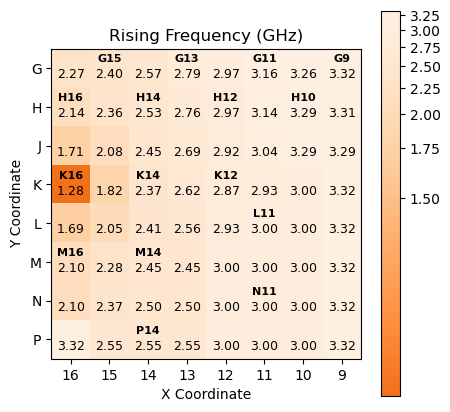

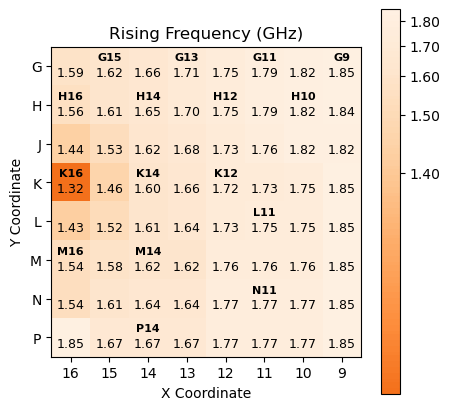

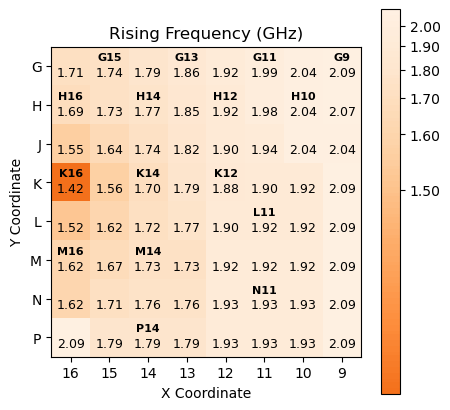

In [8]:
new_matrix_data0 = process_matrix_data(0, matrix_size, xballshift, yballshift)
new_matrix_data1 = process_matrix_data(1, matrix_size, xballshift, yballshift)
new_matrix_data2 = process_matrix_data(2, matrix_size, xballshift, yballshift)

plot_matrix_data(new_matrix_data0, offsets[0])
plot_matrix_data(new_matrix_data1, offsets[1])
plot_matrix_data(new_matrix_data2, offsets[2])